In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import csv
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, optimizers, utils, initializers
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras import layers, optimizers
from kerastuner.tuners import RandomSearch, Hyperband
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from tensorflow.keras.models import load_model
from IPython.display import Image
from keras.utils.vis_utils import plot_model
import kerastuner as kt

# Fingerprinting - 3 classes -1 Server

In this notebook, we are doing fingerprinting on BLE packets, meaning that we are trying to identify an emitter based on the traffic it emits. We are using data from Scenario 5, in which the emitter and the server are still, using 3 nRF52 dev kits used as BLE advertising devices, 4 USRPs used as receivers. We are using raw IQ data as input. 
We are using data solely from Scene 35, Scene 36 and Scene 37 in which only one emitter is advertising. In Scene 35 it is a nRF52 apuN2, in Scene 36 it is a nRF52 apuP22, and in Scene 37 it is a nRF52 apuQ2. This means that we now have 3 classes, considering each scene (i.e. each emitter) as a class. We are using data solely from one server, Server 11, and only one packet length, 1520, since they are the most represented in the dataset.

| Scene | 35 | 36 | 37 |
| --- | --- | --- | --- |
| Server 9 | X | X | X |
| --- | --- | --- | --- |
| Server 11 | X | X | X |
| --- | --- | --- | --- |
| Server 12 | X | X | X |
| --- | --- | --- | --- |
| Server 15 | X | X | X |
| --- | --- | --- | --- |
| nRF52 apuN2 | X |   |   |
| --- | --- | --- | --- |
| nRF52 apuP22 |   | X |   |
| --- | --- | --- | --- |
| nRF52 apuQ2 |   |   | X |
| --- | --- | --- | --- |
| Duration (s) | 60 | 60 | 60 |
| --- | --- | --- | --- |
| Number of executions | 3 | 2 | 3 |

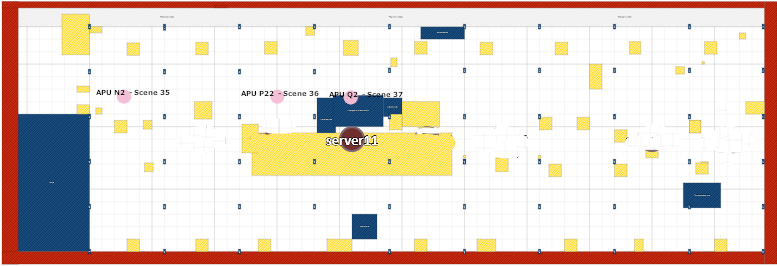

In [19]:
Image("../img/1server_353637.PNG")

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
files=('../data/processed/scenario5_scene35.csv','../data/processed/scenario5_scene36.csv','../data/processed/scenario5_scene37.csv')

idata = pd.concat([pd.read_csv(f) for f in files])


In [22]:
print(idata['Server_id'].value_counts())

print(idata['Len Packet'].value_counts())

11    1770600
9     1760720
15    1515080
12    1387200
Name: Server_id, dtype: int64
1520    5976640
1880     246280
1360     161840
880       28160
1320      17160
1760       3520
Name: Len Packet, dtype: int64


In [23]:
#selecting data from server 11 only and with pkt len=1520
idata=idata[idata['Server_id']==11]

idata=idata[idata['Len Packet']==1520]
print(len(idata.index))

1655280


In [24]:
#balance classes
value_counts = np.array(idata['Scene'].value_counts())
min_sample=min(value_counts)

idata_five=idata[idata['Scene']==35]
idata_six=idata[idata['Scene']==36]
idata_seven=idata[idata['Scene']==37]

idata_five=idata_five.iloc[:min_sample,:]
idata_six=idata_six.iloc[:min_sample,:]
idata_seven=idata_seven.iloc[:min_sample,:]

idata=pd.concat([idata_five, idata_six, idata_seven], ignore_index=True)

print(idata['Scene'].value_counts())

37    346560
36    346560
35    346560
Name: Scene, dtype: int64


In [25]:
#shuffle packets (group of 1520 samples)
print(idata.iloc[::1520, :])
idata=idata.reset_index(drop=True)
index_list = np.array(idata.index)
np.random.shuffle(np.reshape(index_list, (-1, 1520)))

idata = idata.loc[index_list, :]
idata=idata.reset_index(drop=True)
print(idata.iloc[0:1520, :])

                                Time  Len Packet  Central Frequency     X   Y  \
0        2020-11-12T15:57:40.736232Z        1520         2402000000  3009  94   
1520     2020-11-12T15:57:40.736320Z        1520         2402000000  3009  94   
3040     2020-11-12T15:57:40.736379Z        1520         2402000000  3009  94   
4560     2020-11-12T15:57:40.736432Z        1520         2402000000  3009  94   
6080     2020-11-12T15:57:40.736535Z        1520         2402000000  3009  94   
...                              ...         ...                ...   ...  ..   
1032080  2020-11-12T16:07:36.897429Z        1520         2480000000  3009  94   
1033600  2020-11-12T16:07:36.897517Z        1520         2480000000  3009  94   
1035120  2020-11-12T16:07:36.897604Z        1520         2480000000  3009  94   
1036640  2020-11-12T16:07:36.897692Z        1520         2480000000  3009  94   
1038160  2020-11-12T16:07:36.897782Z        1520         2480000000  3009  94   

                           

## Creating Neural Network input

We are creating input for the CNN: X is composed of 1520 IQ samples, and Y is the scene number, meaning the emitter used in each of these scenes. The input data, i.e. the IQ data are normalized.

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
idata[['real','im']]=scaler.fit_transform(idata[['real','im']].values)

### Use the whole packet as input

In this case, we use the whole packet (i.e. 1520 IQ samples as input). Thus, the input has the following shape (1520,2).

In [27]:
def input_whole_pkt(idata):
    #creating input for CNN: IQ values for a whole pkt     output: scene = robot_node
    X=list()
    Y=list()

    pkt_len=1520

    i=0
    while i<len(idata.index):
        data=idata.iloc[i:i+pkt_len]
        if len(data['Time'].unique())==1:
            data=np.array(data[['real','im']], dtype='float64')
            x=data.reshape(pkt_len,2)
            X.append(x)
            Y.append(int(idata.iloc[i]['Scene']))  #in each scene a different emitter is used ~ robot_node in that case
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)

    input_shape=(pkt_len,2)
    batch_size=10
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, batch_size)

### Use only part of the packet as input

In this case, we use only a fraction f of each packet, always of the same length and at the same position in the packet. We take only one fraction per packet. Thus, the input has the following shape (f, 2).

In [28]:
def input_part_pkt(idata):
    #creating input for CNN: IQ values for a whole pkt     output: robot_node
    X=list()
    Y=list()
    pkt_len=1520
    i=0
    while i<len(idata.index):
        data=idata.iloc[i+744:i+944]
        if len(data['Time'].unique())==1:
            data=np.array(data[['real','im']], dtype='float64')
            x=data.reshape((200),2)
            X.append(x)
            Y.append(int(idata.iloc[i]['Scene']))  #in each scene a different emitter is used ~ robot_node in that case
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)
    
    batch_size=10
    input_shape=(200,2)
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, batch_size)

### Creates overlapping slices of each packet and gather them into a batch

In this cas, we use a fraction f (called slice) of a packet for each input, but the slices are overlapping. This means that there are several slices corresponding to the same packet. Moreover, since the slices are overlapping, it means that the same IQ samples can be found in several slices.

In [29]:
def input_slices_pkt(idata, len_slice, shift):
    #creating input for CNN: IQ values for a whole pkt     output: robot_node
    X=list()
    Y=list()
    pkt_len=1520
    i=0
    while i<len(idata.index):
        data=idata.iloc[i:i+pkt_len]
        if len(data['Time'].unique())==1:
            data=np.array(data[['real','im']], dtype='float64')
            x=data.reshape((pkt_len),2)
            #creates slices of the packet and gather them in a single batch
            x=tf.data.Dataset.from_tensor_slices(x)
            x = x.window(len_slice, shift, 1, True)
            count=0
            for window in x:
                X.append(list(window.as_numpy_iterator()))
                count=count+1

                Y.append(int(idata.iloc[i]['Scene']))  #in each scene a different emitter is used ~ robot_node in that case
        else:
            print(i)
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)

    input_shape=X[0].shape
    nb_slice=count
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, nb_slice)

We are attributing a class number (0,1,2) to each scene: 35 is 0, 36 is 1 and 37 is 2.

In [30]:
def name_classes(Y):
    Y_change=list()

    #35:0, 36:1 37:2
    for i in Y:
        if i==35:
            Y_change.append(0)
        elif i==36:
            Y_change.append(1)
        elif i==37:
            Y_change.append(2)

    Y_change=np.array(Y_change)
    
    return Y_change

In [36]:
def data_preparation_nn(idata, type_input, len_slice, shift):
    if type_input=='whole':
        X,Y,input_shape,nb_slice=input_whole_pkt(idata)
    elif type_input=='part':
        X,Y,input_shape,nb_slice=input_part_pkt(idata)
    elif type_input=='slice':
        X,Y,input_shape,nb_slice=input_slices_pkt(idata, len_slice, shift)
   
    Y_change=name_classes(Y)
    
    unique_elements, counts_elements = np.unique(Y_change, return_counts=True)
    nb_class=max(unique_elements)+1
        
    Y_cat=utils.to_categorical(Y_change, num_classes=nb_class)

    #X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, shuffle=False) #for the per packet prediction
    X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2) #for the per slice prediction 
    return(X_train, X_test, y_train, y_test, input_shape, nb_slice)

## Performances

We use the following functions to estimate the performances of the various models we will be testing.

This function plots the accuracy (i.e. the number of correctly classified elements over the total number of elements) during training, as well as the validation accuracy (i.e. the accuracy of the model on the validation set).

In [32]:
def plot_accuracy(history):
    i = np.arange(len(history.history['loss']))
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.plot(i, history.history['accuracy'], label='accuracy')
    plt.plot(i, history.history['val_accuracy'], label='val_accuaracy')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

This function gathers the metrics we will need to estimate the performances of a model on the train set. The confusion matrix allows us to visualize how many elements of each class have been accurately classified, how many have been wrongly classified and in this case with which other class they have been getting mixed up.
We also have the f1-score for each class, which quantifies the trade-off between the precision (i.e. how many elements classified as a given class are actually part of this class) and the recall (i.e. how many elements actually part of a given class have been classified as such). We alse compute the global f1-score, which is a weighted mean of the f1-score for each class. Finally, we can see the global accuracy.

In [33]:
def test_metrics(model, y_test, X_test):
    predictions= model.predict(X_test)
    predictions = [np.argmax(y, axis=0, out=None) for y in predictions]
    y_test_cat = [np.argmax(y, axis=0, out=None) for y in y_test]
    
    present_class_list=np.unique(y_test_cat)

    # Confusion Matrix
    conf_mat=confusion_matrix(y_test_cat, predictions, labels=present_class_list)

    #F1-score
    print("f1_score for each class")
    f1_each=f1_score(y_test_cat, predictions, average=None, labels=present_class_list)
    print(f1_each)

    #F1-score
    print("Global f1_score")
    print(f1_score(y_test_cat, predictions, average='weighted'))

    #accyracy
    print("Global accuracy")
    print(accuracy_score(y_test_cat,predictions))

    cmap = sns.diverging_palette(200, 10, as_cmap=True)
    sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

In [34]:
def print_graph(model,model_name):
    name='../img/'+model_name+'.png'
    plot_model(model, to_file=name, show_shapes=True)
    return name


## CNN 1 / AlexNet 1D

We are first trying a feedforward CNN, inspired by the one in the following article: "More is better: Data Augmentation for channel-Resilient RF Fingerprinting" by Nasim Soltani. It is also described in "RF Fingerprinting Unnanned Aerial Vehicles with Non-Standard Transmitter Waveforms", in which it is called AlexNet1D. We started with the CNN described in the articles, before trying out various sizes and types of inputs. We quickly saw that the 'slices' approach for the input gave far better results than the other types of input. We also added a Gaussian Noise layer, as a Data Augmentation tool to make the model more robust. We also added a BatchNormalization layer, in order to normalize each batch, adding that to the normalization we already performed on the whole dataset.

| CNN 1 type | Test Accuracy | Comments |
| --- | --- | --- |
| Initial | 0.37 | Overfits a lot|
| --- | --- | --- |
| Initial + Gaussian noise (0.04) | 0.37 | Overfits a lot|
| --- | --- | --- |
| Initial + Gaussian noise (0.04) +Dropout 0,5| 0.38 | Overfits a lot|
| --- | --- | --- |
| Initial + Gaussian noise (0.1) +Dropout 0,7| 0.35 |/|
| --- | --- | --- |
| Only one Conv1d+MaxPooling block| 0.37 |Overfits even more|
| --- | --- | --- |
| 7 Conv1d+MaxPooling block| 0.31 |Overfits even more|
| --- | --- | --- |
| Activ function 'relu' instead of 'tanh'| 0.36 |Overfits even more|
| --- | --- | --- |
|Using only 200 samples in the payload as input| 0.40 |Overfits|
| --- | --- | --- |
|Using slices (200 samples, 150 shift) as input| 0.45 |Overfits a little less!|
| --- | --- | --- |
|Using slices (500 samples, 50 shift) as input| 0.56 |Almost no overfitting|
| --- | --- | --- |
|Using slices (1000 samples, 50 shift) as input| 0.40 |Overfitting|
| --- | --- | --- |
|Using slices (200 samples, 50 shift) as input| 0.67 |Nooverfitting|
| --- | --- | --- |
|Using slices (200 samples, 50 shift) as input, BatchNormalization instead of global| 0.60 |Little overfitting|
| --- | --- | --- |
|Using slices (200 samples, 50 shift) as input, BatchNormalization and global normalization| 0.65 |Little overfitting|
| --- | --- | --- |
|Tuned version| 0.84 |~|
| --- | --- | --- |
|Tuned version but batchnorm after gaussian noise| 0.6 |~|
| --- | --- | --- |
|Using all slices| 0.5 |overfits a lot|
| --- | --- | --- |
|Using all slices- tuned version| 0.93 |-|

In [131]:
X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 450, 30)

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1,input_shape=input_shape))

for i in range(3):
    model.add(layers.Conv1D(filters=140, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.Conv1D(filters=300, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))

model.add(layers.Dense(units=650))
model.add(layers.Dense(units=400))

model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=60, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Il y a 24624 échantillons
Epoch 1/300
263/263 [==============================] - 6s 22ms/step - loss: 1.1021 - accuracy: 0.3463 - val_loss: 1.0989 - val_accuracy: 0.3442
Epoch 2/300
263/263 [==============================] - 5s 20ms/step - loss: 1.0854 - accuracy: 0.3735 - val_loss: 1.0925 - val_accuracy: 0.3617
Epoch 3/300
263/263 [==============================] - 5s 20ms/step - loss: 1.0628 - accuracy: 0.4009 - val_loss: 1.0814 - val_accuracy: 0.3774
Epoch 4/300
263/263 [==============================] - 5s 20ms/step - loss: 1.0366 - accuracy: 0.4221 - val_loss: 1.0751 - val_accuracy: 0.3810
Epoch 5/300
263/263 [==============================] - 5s 20ms/step - loss: 1.0067 - accuracy: 0.4517 - val_loss: 1.0553 - val_accuracy: 0.4018
Epoch 6/300
263/263 [==============================] - 5s 20ms/step - loss: 0.9688 - accuracy: 0.4816 - val_loss: 1.0505 - val_accuracy: 0.4546
Epoch 7/300
263/263 [==============================] - 5s 20ms/step - loss: 0.9385 - accuracy: 0.5030 - val_lo

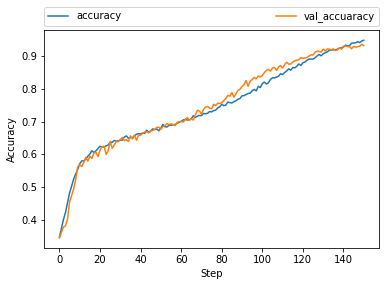

f1_score for each class
[0.93139679 0.93230769 0.93103448]
Global f1_score
0.9315752644801483
Global accuracy
0.9315736040609137


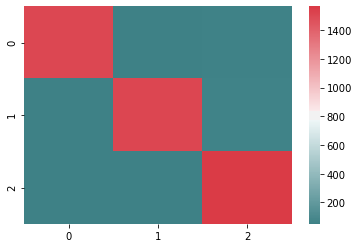

In [132]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

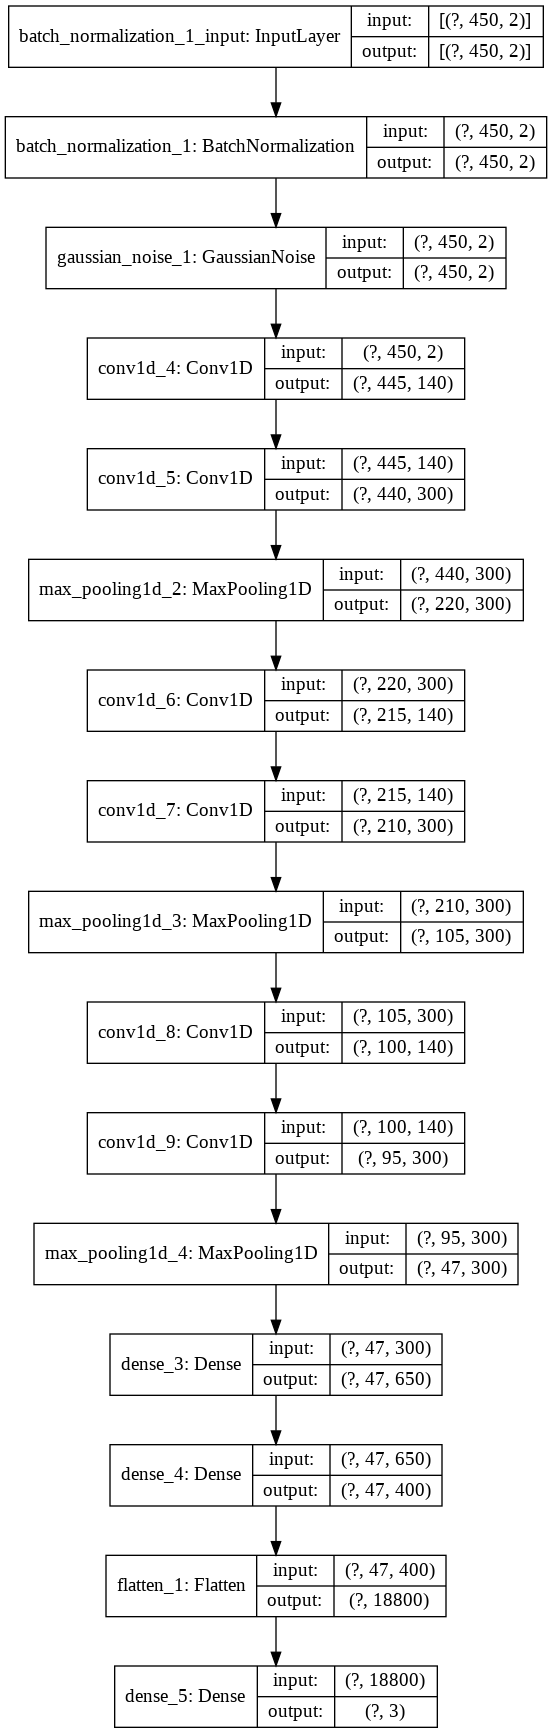

In [133]:
name=print_graph(model, 'AlexNet')
Image(retina=True, filename=name)

To get even better results, we used Keras HyperTuner, which randomly tests out various hyperparametrers combinations specified by the user and choose the best one according to a given metric (here: validation accuracy). This task was done doing the research part of the project in this notebook using the following code: now it is done using tune_model.py in /src folder.

In this function, we define the model we want to tune, as well as the range of the various hyperparameters:

def build_model(h):
    try:
        model = models.Sequential()
        model.add(layers.BatchNormalization(input_shape=(h.get('len_slice'),2)))
        model.add(layers.GaussianNoise(0.1))

        for i in range(h.Int('blocks', 1, 4,1, default=4)):
            model.add(layers.Conv1D(filters=h.Int('filters_1', 10, 500,10, default=128), kernel_size=h.Int('kernal_1', 2, 10,1, default=7), 
                                    padding='valid',activation=h.Choice(
                        'activation_1',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))
            model.add(layers.Conv1D(filters=h.Int('filters_1_2', 10, 500,10, default=128), kernel_size=h.Int('kernal_1_2', 2, 10,1, default=5), 
                                    padding='valid',activation=h.Choice(
                        'activation_1_2',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))
            model.add(layers.MaxPooling1D((2)))


        model.add(layers.Dense(units=h.Int('filters_dense_1', 100, 1000,50, default=256)))
        model.add(layers.Dense(units=h.Int('filters_dense_2', 100, 1000,50, default=128)))

        model.add(layers.Flatten())
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(learning_rate =0.0001),
                  loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    except:
        model = models.Sequential()
        model.add(layers.BatchNormalization(input_shape=(h.get('len_slice'),2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                      loss=tf.keras.losses.categorical_crossentropy,
                      metrics=['accuracy'])
    
    return model

This class defines the tuner (allowing us to tune parameters that are not part of the model such as the lengh of the slices), and run each trial

class MyTuner(kt.Tuner):
    
    def run_trial(self, trial, idata):
        try:
            hp = trial.hyperparameters
            X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 
                            hp.get('len_slice'),hp.get('shift'))
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

            print('XXXXXXXX')
            print(input_shape)
            batch_size=hp.get('batch_size')
            #optimizer = tf.keras.optimizers.Adam(0.001)
            model = self.hypermodel.build(trial.hyperparameters)
            history=model.fit(X_train, y_train, batch_size=batch_size, epochs=300, verbose=1, validation_split=0.2,
                     callbacks=[callback])
            #loss = model.evaluate(X_test, y_test)
            acc=history.history.get('val_accuracy')[-1]
            self.oracle.update_trial(
              trial.trial_id, {'val_acc': acc})
            self.save_model(trial.trial_id, model)
        except ValueError:
            self.oracle.update_trial(trial.trial_id, {'val_acc': 0})

This launches the tuner and prints the results

hp = kt.HyperParameters()
hp.Int('len_slice', 50, 1000,100, default=200)
hp.Int('shift', 10, 500,10, default=50)
hp.Int('batch_size', 10, 70,10, default=30)

tuner_rs = MyTuner(
      oracle=kt.oracles.BayesianOptimization(
          objective=kt.Objective('val_acc', 'max'),
          max_trials=20, hyperparameters=hp),
      hypermodel=build_model,
      overwrite=True)


tuner_rs.search_space_summary()



tuner_rs.search(idata=idata)
                #epochs=300, validation_split=0.2, verbose=1, callbacks=[callback])

tuner_rs.results_summary()

best_model = tuner_rs.get_best_models(num_models=1)[0]

## CNN 2

| Experiments | Test Accuracy | Comments |
| --- | --- | --- |
| Initial | 0.39 | Overfits a lot|
| --- | --- | --- |
| Initial + 200 samples part | 0.40 | Overfits a lot|
| --- | --- | --- |
| Initial + Slices (200, shift=150)| 0.46 | Overfits a little less|
| --- | --- | --- |
| Initial + Slices (200, shift=150)| 0.57 | Almost no overfitting|
| --- | --- | --- |
| Tuned version| 0.71 | Almost no overfitting|
| --- | --- | --- |
| Using all slices-Tuned version| 0.38 | overfitting|


We are now trying a more complex CNN, also described in the same article. We can see that, as CNN1, this model performs better with a 'slice' input. We also added the same GaussianNoise and BatchNormalization layers as above. Nevertheless, even after hyperparameter tuning, this model performs a little worse than CNN1.

In [55]:
X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 550, 460)

steps=300

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.51))
for i in range(2):
    model.add(layers.Conv1D(filters=270, kernel_size=(6), padding='valid',activation='sigmoid'))
    model.add(layers.MaxPooling1D((2)))
    model.add(layers.Dense(units=150))


model.add(layers.Dense(units=800))

model.add(layers.Flatten())          
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=nb_slice, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Il y a 3267 échantillons
(array([35, 36, 37]), array([684, 684, 684]))
Epoch 1/300
438/438 [==============================] - 16s 38ms/step - loss: 1.1584 - accuracy: 0.3506 - val_loss: 1.1782 - val_accuracy: 0.3465
Epoch 2/300
438/438 [==============================] - 4s 9ms/step - loss: 1.1478 - accuracy: 0.3300 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 3/300
438/438 [==============================] - 4s 9ms/step - loss: 1.1217 - accuracy: 0.3430 - val_loss: 1.1035 - val_accuracy: 0.3252
Epoch 4/300
438/438 [==============================] - 4s 9ms/step - loss: 1.1061 - accuracy: 0.3445 - val_loss: 1.1224 - val_accuracy: 0.3252
Epoch 5/300
438/438 [==============================] - 4s 9ms/step - loss: 1.1273 - accuracy: 0.3354 - val_loss: 1.1184 - val_accuracy: 0.3252
Epoch 6/300
438/438 [==============================] - 4s 9ms/step - loss: 1.1137 - accuracy: 0.3300 - val_loss: 1.1558 - val_accuracy: 0.3252
Epoch 7/300
438/438 [==============================] - 4s 10ms/step -

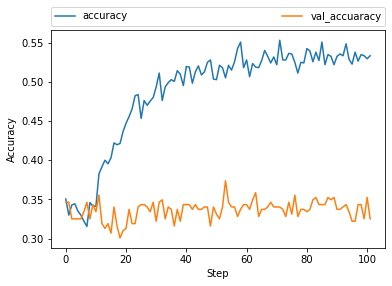

f1_score for each class
[0.2295082  0.47008547 0.16374269]
Global f1_score
0.28293600291232285
Global accuracy
0.35279805352798055


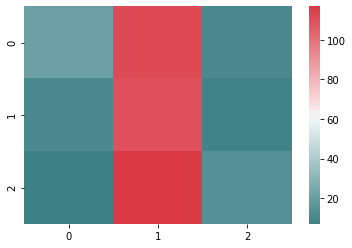

In [56]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

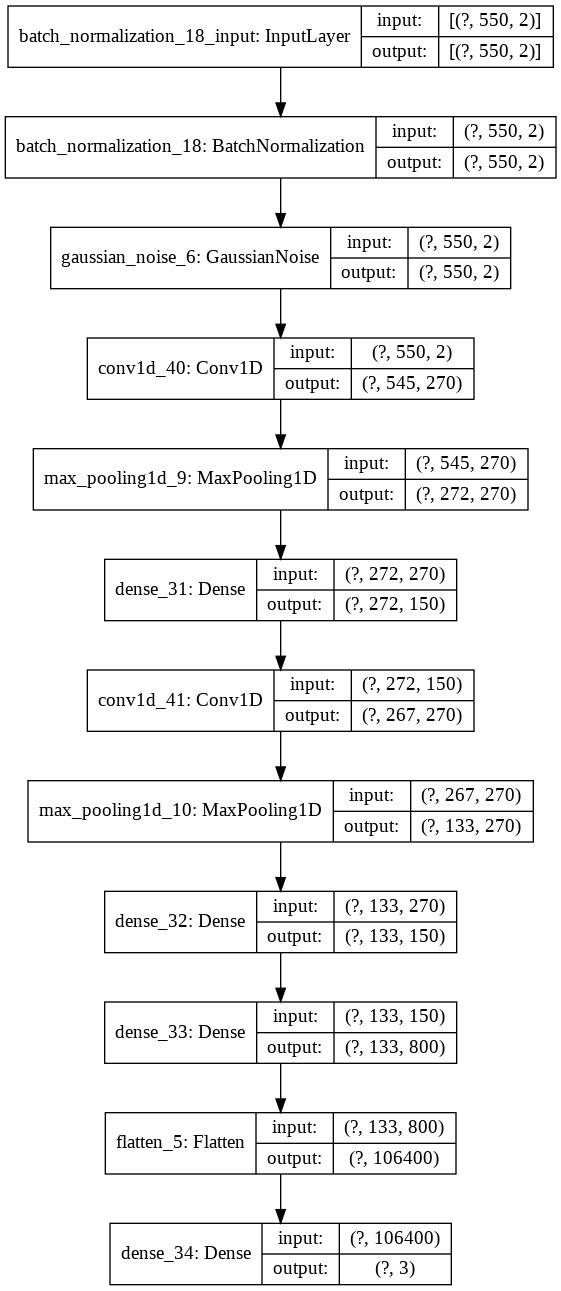

In [57]:
name=print_graph(model, 'CNN2')
Image(retina=True, filename=name)

def build_model(h):
    try:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)

        model = models.Sequential()
        model.add(layers.BatchNormalization(input_shape=(h.get('len_slice'),2)))
        model.add(layers.GaussianNoise(h.Float('stev', 0.01, 1,0.1, default=0.5)))
        for i in range(h.Int('blocks', 1, 4,1, default=4)):
            model.add(layers.Conv1D(filters=h.Int('filters_1', 10, 500,10, default=128), kernel_size=(h.Int('kernal_1', 2, 10,1, default=7)), 
                                    padding='valid',activation=h.Choice(
                        'activation_1',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))
            model.add(layers.MaxPooling1D((2)))
            model.add(layers.Dense(units=h.Int('filters_dense_1', 100, 1000,50, default=128)))

        model.add(layers.Dense(units=h.Int('filters_dense_2', 100, 1000,50, default=128)))


        model.add(layers.Flatten())          
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(learning_rate =  h.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    except:
        model = models.Sequential()
        model.add(layers.BatchNormalization(input_shape=(h.get('len_slice'),2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                      loss=tf.keras.losses.categorical_crossentropy,
                      metrics=['accuracy'])
    
    return model

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
    patience=100)

hp = kt.HyperParameters()
hp.Int('len_slice', 50, 1000,100, default=200)
hp.Int('shift', 10, 500,10, default=50)

tuner_rs = MyTuner(
      oracle=kt.oracles.BayesianOptimization(
          objective=kt.Objective('accuracy', 'max'),
          max_trials=20, hyperparameters=hp),
      hypermodel=build_model,
      overwrite=True)


tuner_rs.search_space_summary()



tuner_rs.search(idata=idata)
                #epochs=300, validation_split=0.2, verbose=1, callbacks=[callback])

tuner_rs.results_summary()

best_model = tuner_rs.get_best_models(num_models=1)[0]

## Conv RNN

Let's now try out the third model described in the article, which is a Convolutional Recurrent Network. As for the previous models, the slice input works better. We also added the GaussianNoise and BatchNormalization layers. Nevertheless, even after tuning, this model performs a little worse than CNN1.

| Experiments | Test Accuracy | Comments |
| --- | --- | --- |
| Initial | 0.33 | Overfits a lot|
| --- | --- | --- |
| Initial + part (200 samples) | 0.40 | Overfits a lot|
| --- | --- | --- |
| Initial + Slices (200, shift:150)| 0.44 | Overfits a lot|
| --- | --- | --- |
| Initial + Slices (500, shift:50)| 0.57 | Overfits a little|
| --- | --- | --- |
| Tuned| 0.72 | Overfits a little|
| --- | --- | --- |
| Using all slices| 0.49 | Overfits a little|


In [35]:
X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 500, 50)

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)


model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))
for i in range(2):
    model.add(layers.Conv1D(filters=430, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))


model.add(layers.SimpleRNN(units=400,activation="relu"))

model.add(layers.Dense(units=250))
model.add(layers.Dense(units=350))

model.add(layers.Flatten())          
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=nb_slice, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
438/438 [==============================] - 29s 66ms/step - loss: 1.0995 - accuracy: 0.3538 - val_loss: 1.0981 - val_accuracy: 0.3486
Epoch 2/300
438/438 [==============================] - 16s 36ms/step - loss: 1.0948 - accuracy: 0.3526 - val_loss: 1.0968 - val_accuracy: 0.3486
Epoch 3/300
438/438 [==============================] - 16s 37ms/step - loss: 1.0916 - accuracy: 0.3537 - val_loss: 1.0970 - val_accuracy: 0.3574
Epoch 4/300
438/438 [==============================] - 16s 37ms/step - loss: 1.0894 - accuracy: 0.3645 - val_loss: 1.1002 - val_accuracy: 0.3553
Epoch 5/300
438/438 [==============================] - 16s 36ms/step - loss: 1.0879 - accuracy: 0.3672 - val_loss: 1.0938 - val_accuracy: 0.3604
Epoch 6/300
438/438 [==============================] - 16s 37ms/step - loss: 1.0827 - accuracy: 0.3724 - val_loss: 1.1022 - val_accuracy: 0.3550
Epoch 7/300
438/438 [==============================] - 16s 37ms/step - loss: 1.0815 - accuracy: 0.3718 - val_loss: 1.1003 - val_ac

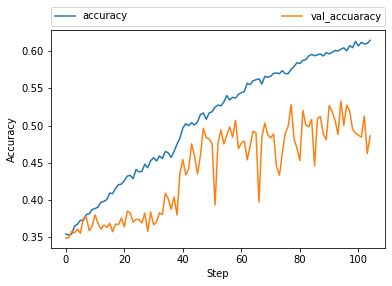

f1_score for each class
[0.51166966 0.46683292 0.4732974 ]
Global f1_score
0.4837741824863563
Global accuracy
0.4889009204114781


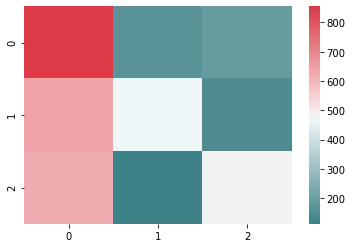

In [38]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

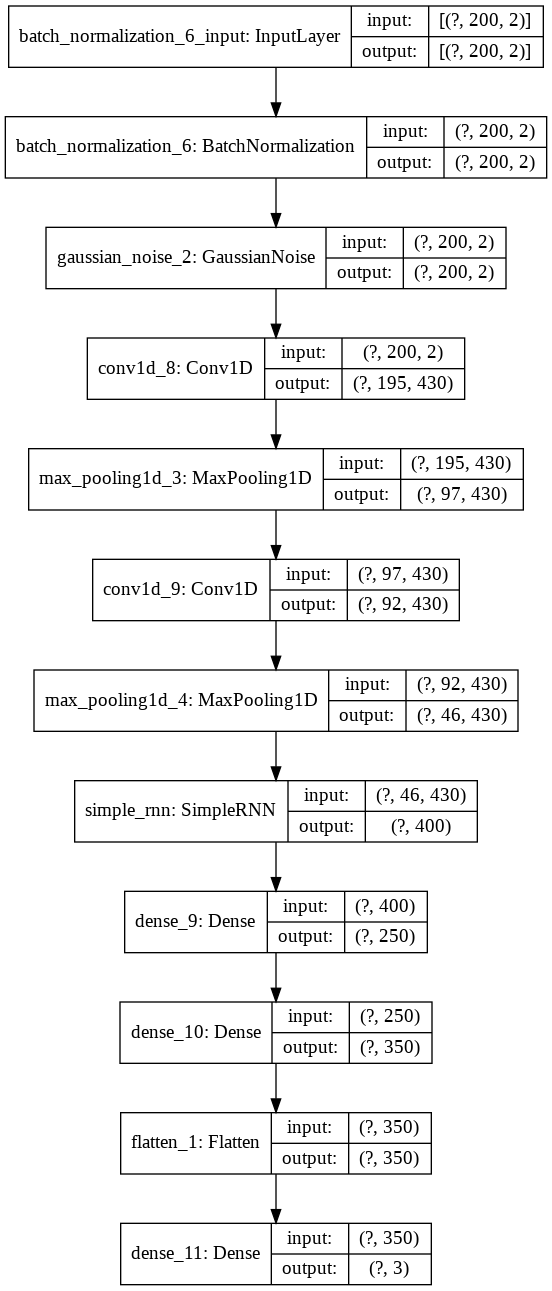

In [39]:
name=print_graph(model, 'ConvRNN')
Image(retina=True, filename=name)

def build_model(h):
    try:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)

        model = models.Sequential()
        model.add(layers.BatchNormalization(input_shape=(h.get('len_slice'),2)))
        model.add(layers.GaussianNoise(h.Float('stev', 0.01, 1,0.1, default=0.5)))
        for i in range(h.Int('blocks', 1, 4,1, default=4)):
            model.add(layers.Conv1D(filters=h.Int('filters_1', 10, 500,10, default=128), kernel_size=(h.Int('kernal_1', 2, 10,1, default=7)), 
                                    padding='valid',activation=h.Choice(
                        'activation_1',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))
            model.add(layers.MaxPooling1D((2)))

        model.add(layers.SimpleRNN(units=h.Int('filters_rnn', 10, 500,10, default=512),activation=h.Choice(
                        'activation_rnn',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))

        model.add(layers.Dense(units=h.Int('filters_dense_1', 100, 1000,50, default=256)))

        model.add(layers.Dense(units=h.Int('filters_dense_2', 100, 1000,50, default=128)))


        model.add(layers.Flatten())          
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(learning_rate =  h.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    except:
        model = models.Sequential()
        model.add(layers.BatchNormalization(input_shape=(h.get('len_slice'),2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                      loss=tf.keras.losses.categorical_crossentropy,
                      metrics=['accuracy'])
    
    return model

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
    patience=100)

hp = kt.HyperParameters()
hp.Int('len_slice', 50, 1000,100, default=200)
hp.Int('shift', 10, 500,10, default=50)

tuner_rs = MyTuner(
      oracle=kt.oracles.BayesianOptimization(
          objective=kt.Objective('accuracy', 'max'),
          max_trials=20, hyperparameters=hp),
      hypermodel=build_model,
      overwrite=True)


tuner_rs.search_space_summary()



tuner_rs.search(idata=idata)
                #epochs=300, validation_split=0.2, verbose=1, callbacks=[callback])

tuner_rs.results_summary()

best_model = tuner_rs.get_best_models(num_models=1)[0]

## ResNet 1D

We now try another model described in "Fingerprinting Unmanned Aerial Vehicles withNon-standard Transmitter Waveforms". It is inspired by the ResNet architecture. We tested it directly on the slices input, using a GaussianNoise and BtachNormalization layers. We kept only the blocks up to 128 filters, otherwise the tensors became quickly too big.

| Experiments | Test Accuracy | Comments |
| --- | --- | --- |
| Initial+BatchNorm+Gaussian Noise 0.1 (only blocks until 128)+ Slice input| 0.72 | Overfits a little|
| --- | --- | --- |
| Using all slices| 0.56 | Overfits a little|



In [20]:
def proj_block(x: tf.Tensor, filters):
    y_first = layers.Conv1D(kernel_size=1,
               filters=filters,
               padding="same", activation='relu')(x)
    y_first = layers.Conv1D(kernel_size=3,
               filters=filters,
               activation='relu')(y_first)
    y_first = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               activation='relu')(y_first)
    
    y_second = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               padding="same", activation='relu')(x)
    
    y = layers.concatenate([y_first,  y_second], axis=1)
    y = layers.Activation(activation='relu')(y)

    return y

In [21]:
def id_block(x: tf.Tensor, filters):
    y_first = layers.Conv1D(kernel_size=1,
               filters=filters,
               padding="same", activation='relu')(x)
    y_first = layers.Conv1D(kernel_size=3,
               filters=filters,
               activation='relu')(y_first)
    y_first = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               activation='relu')(y_first)
    
    y = layers.concatenate([y_first,  x], axis=1)
    y = layers.Activation(activation='relu')(y)

    return y

In [17]:
X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 500, 50)

Il y a 1089 échantillons
(array([35, 36, 37]), array([228, 228, 228]))


In [42]:

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

inputs = layers.Input(shape=input_shape)

t=layers.BatchNormalization()(inputs)
t=layers.GaussianNoise(0.1)(t)
t=layers.Conv1D(kernel_size=7,
               filters=64,
               activation='relu')(t)
t=layers.MaxPool1D(2)(t)
t=proj_block(t,64)
for i in range(2):
    t=id_block(t,64)

t=proj_block(t,128)
for j in range(3):
    t=id_block(t,128)

t=layers.AveragePooling1D(2)(t)
t=layers.Flatten()(t)
outputs=layers.Dense(3,activation='softmax')(t)

model = tf.keras.models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=nb_slice, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
438/438 [==============================] - 199s 453ms/step - loss: 1.0986 - accuracy: 0.3467 - val_loss: 1.0969 - val_accuracy: 0.3442
Epoch 2/300
438/438 [==============================] - 47s 107ms/step - loss: 1.0901 - accuracy: 0.3635 - val_loss: 1.0917 - val_accuracy: 0.3658
Epoch 3/300
438/438 [==============================] - 47s 107ms/step - loss: 1.0735 - accuracy: 0.3866 - val_loss: 1.0844 - val_accuracy: 0.3756
Epoch 4/300
438/438 [==============================] - 47s 107ms/step - loss: 1.0524 - accuracy: 0.4050 - val_loss: 1.0900 - val_accuracy: 0.3753
Epoch 5/300
438/438 [==============================] - 45s 103ms/step - loss: 1.0289 - accuracy: 0.4214 - val_loss: 1.0939 - val_accuracy: 0.3794
Epoch 6/300
438/438 [==============================] - 43s 99ms/step - loss: 1.0109 - accuracy: 0.4342 - val_loss: 1.0897 - val_accuracy: 0.3871
Epoch 7/300
438/438 [==============================] - 43s 98ms/step - loss: 0.9892 - accuracy: 0.4431 - val_loss: 1.1086 - 

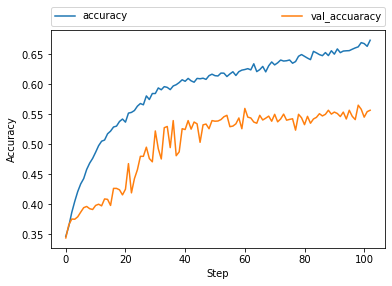

f1_score for each class
[0.41230769 0.61231884 0.62509335]
Global f1_score
0.5504776196949317
Global accuracy
0.5641580942068218


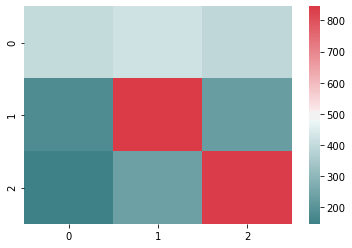

In [45]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

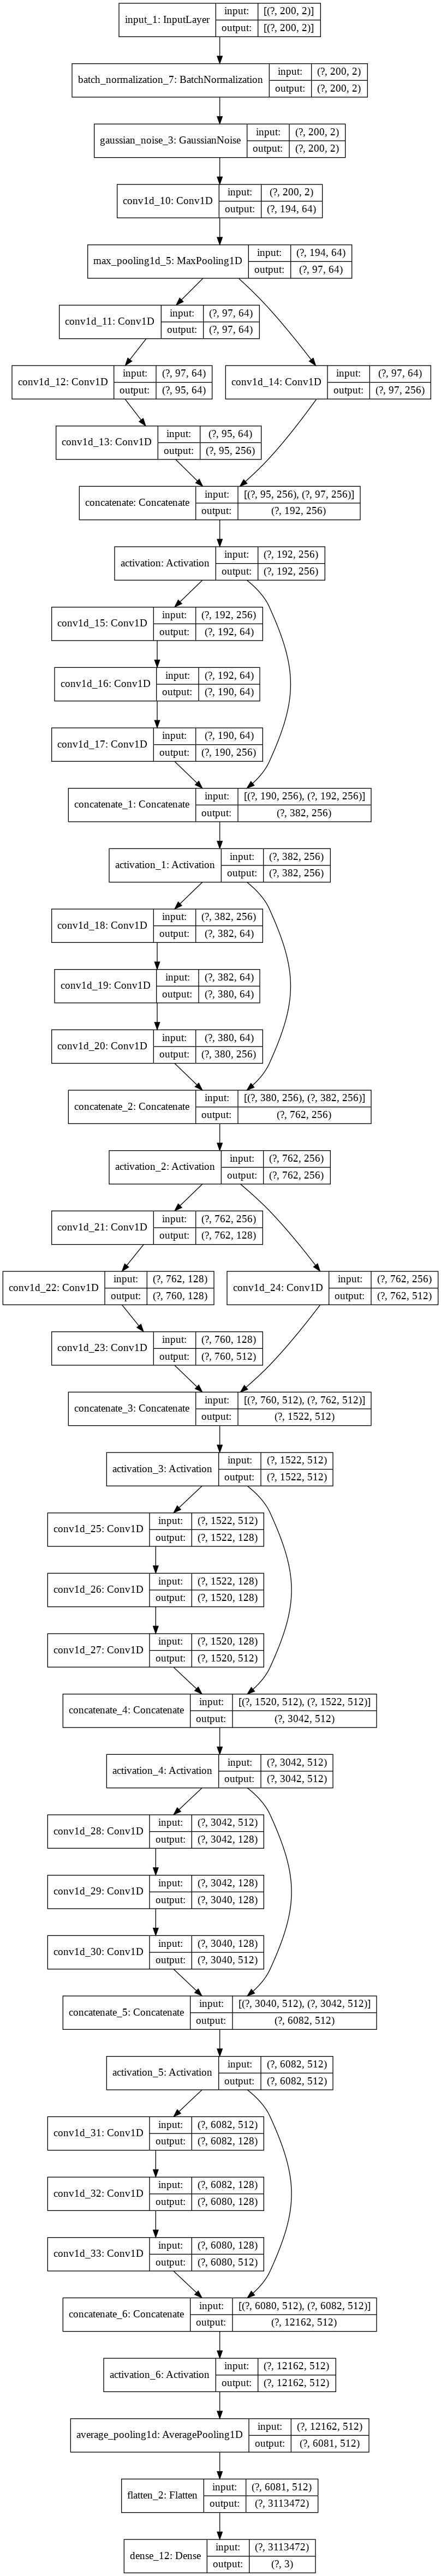

In [46]:
name=print_graph(model, 'ResNet1D')
Image(retina=True, filename=name)

def build_model(h):
    try:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)

        inputs = layers.Input(shape=(h.get('len_slice'),2))

        t=layers.BatchNormalization()(inputs)
        t=layers.GaussianNoise(h.Float('stev', 0.01, 1,0.1, default=0.5))(t)
        t=layers.Conv1D(kernel_size=h.Int('kernel_1', 2, 20,1, default=7),
                       filters=h.Int('filters_1', 10, 200,10, default=64),
                       activation=h.Choice(
                        'activation_1',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu'))(t)
        t=layers.MaxPool1D(2)(t)
        f_b_1=h.Int('filters_block_1', 10, 200,10, default=64)
        t=proj_block(t,f_b_1)
        for i in range(h.Int('nb_id_1', 1, 5,1, default=2)):
            t=id_block(t,f_b_1)

        f_b_2=h.Int('filters_block_2', 10, 200,10, default=128)
        t=proj_block(t,f_b_2)
        for j in range(h.Int('nb_id_2', 1, 5,1, default=3)):
            t=id_block(t,f_b_2)
        t=layers.AveragePooling1D(2)(t)
        t=layers.Flatten()(t)
        outputs=layers.Dense(3,activation='softmax')(t)

        model = tf.keras.models.Model(inputs, outputs)

        model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    except:
        model = models.Sequential()
        model.add(layers.BatchNormalization(input_shape=(h.get('len_slice'),2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                      loss=tf.keras.losses.categorical_crossentropy,
                      metrics=['accuracy'])
    
    return model

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
    patience=100)

hp = kt.HyperParameters()
hp.Int('len_slice', 50, 500,100, default=200)
hp.Int('shift', 10, 500,10, default=50)

tuner_rs = MyTuner(
      oracle=kt.oracles.BayesianOptimization(
          objective=kt.Objective('accuracy', 'max'),
          max_trials=20, hyperparameters=hp),
      hypermodel=build_model,
      overwrite=True)


tuner_rs.search_space_summary()



tuner_rs.search(idata=idata)
                #epochs=300, validation_split=0.2, verbose=1, callbacks=[callback])

tuner_rs.results_summary()

best_model = tuner_rs.get_best_models(num_models=1)[0]

## CNN with Conv2D

Until this point, all our CNN were composed solely of Conv1D layers, which means that they would perform a convolution on each channel (real or imaginary data from IQ data) independently. Let's now try a model using Conv2D, which will also take into account the dependency between these two channels. We are using a model described in "Trust in 5G Open RANs through Machine Learning:RF Fingerprinting on the POWDER PAWR Platform". It performs a little worse than CNN1.

| Experiments | Test Accuracy | Comments |
| --- | --- | --- |
| Initial + slices input| 0.68 | No overfitting|
| --- | --- | --- |
| Tuned version | 0.77 | No overfitting|
| --- | --- | --- |
| Using all slices | 0.36 | overfitting|


In [47]:
X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 500, 50)

X_train=X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2],1))
X_test=X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2],1))

input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))

model.add(layers.Conv2D(filters=110, kernel_size=(5,1), padding='valid',activation='tanh'))
model.add(layers.MaxPooling2D((2,1)))
model.add(layers.Conv2D(filters=150, kernel_size=(6,1), padding='valid',activation='relu'))
model.add(layers.MaxPooling2D((2,1)))
model.add(layers.Conv2D(filters=40, kernel_size=(9,2), padding='valid',activation='relu'))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Dense(units=280, activation='relu'))
model.add(layers.Dense(units=480, activation='tanh'))

model.add(layers.Flatten())          
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=nb_slice, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
438/438 [==============================] - 28s 63ms/step - loss: 1.0972 - accuracy: 0.3554 - val_loss: 1.0967 - val_accuracy: 0.3550
Epoch 2/300
438/438 [==============================] - 4s 9ms/step - loss: 1.0952 - accuracy: 0.3498 - val_loss: 1.0949 - val_accuracy: 0.3604
Epoch 3/300
438/438 [==============================] - 4s 9ms/step - loss: 1.0928 - accuracy: 0.3599 - val_loss: 1.0935 - val_accuracy: 0.3611
Epoch 4/300
438/438 [==============================] - 4s 9ms/step - loss: 1.0876 - accuracy: 0.3690 - val_loss: 1.0934 - val_accuracy: 0.3658
Epoch 5/300
438/438 [==============================] - 4s 9ms/step - loss: 1.0799 - accuracy: 0.3757 - val_loss: 1.0940 - val_accuracy: 0.3716
Epoch 6/300
438/438 [==============================] - 4s 9ms/step - loss: 1.0701 - accuracy: 0.3882 - val_loss: 1.0958 - val_accuracy: 0.3536
Epoch 7/300
438/438 [==============================] - 4s 9ms/step - loss: 1.0607 - accuracy: 0.3992 - val_loss: 1.0914 - val_accuracy: 0.37

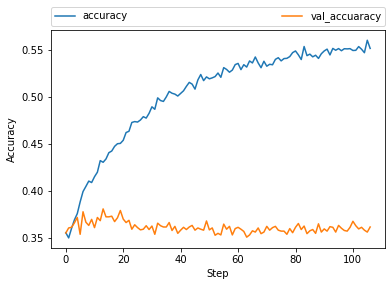

f1_score for each class
[0.47073988 0.24805339 0.22793688]
Global f1_score
0.3149606709889151
Global accuracy
0.3603140227395777


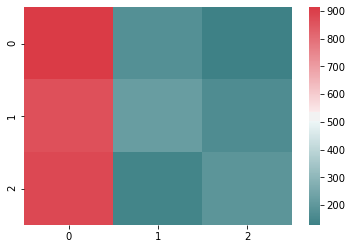

In [48]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

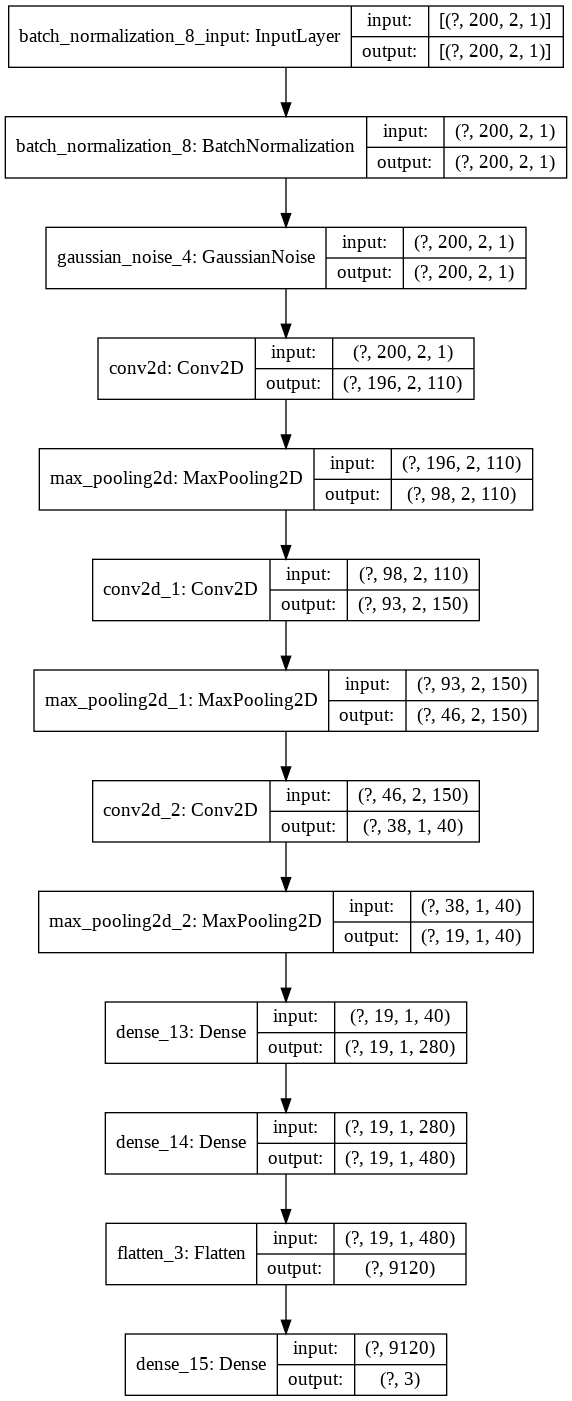

In [49]:
name=print_graph(model, 'CNNConv2D')
Image(retina=True, filename=name)

def build_model(h):
    try:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)


        model = models.Sequential()
        model.add(layers.BatchNormalization(input_shape=input_shape))
        model.add(layers.GaussianNoise(0.1))

        model.add(layers.Conv2D(filters=h.Int('filters_1', 10, 200,10, default=40), kernel_size=(h.Int('kernel_1', 2, 20,1, default=7),1) , padding='valid',activation=h.Choice(
                        'activation_1',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))
        model.add(layers.MaxPooling2D((2,1)))
        model.add(layers.Conv2D(filters=h.Int('filters_2', 10, 200,10, default=40), kernel_size=(h.Int('kernel_2', 2, 20,1, default=5),1),padding='valid',activation=h.Choice(
                        'activation_2',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))
        model.add(layers.MaxPooling2D((2,1)))
        model.add(layers.Conv2D(filters=h.Int('filters_3', 10, 200,10, default=40), kernel_size=(h.Int('kernel_3', 2, 20,1, default=7),2)
                                , padding='valid',activation=h.Choice(
                        'activation_3',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))
        model.add(layers.MaxPooling2D((2,1)))

        model.add(layers.Dense(units=h.Int('filters_d_1', 100, 1000,10, default=1024), activation=h.Choice(
                        'activation_4',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))
        model.add(layers.Dense(units=h.Int('filters_d_2', 100, 1000,10, default=256), activation=h.Choice(
                        'activation_5',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))

        model.add(layers.Flatten())          
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    except:
        model = models.Sequential()
        model.add(layers.BatchNormalization(input_shape=(h.get('len_slice'),2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                      loss=tf.keras.losses.categorical_crossentropy,
                      metrics=['accuracy'])
    
    return model

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
    patience=100)
tuner_rs = RandomSearch(
            build_model,
    objective='val_accuracy',
            seed=42,
            max_trials=20,
            executions_per_trial=2,
            overwrite=True)

tuner_rs.search_space_summary()



tuner_rs.search(X_train, y_train, epochs=300, validation_split=0.2, verbose=1, callbacks=[callback])

tuner_rs.results_summary()

best_model = tuner_rs.get_best_models(num_models=1)[0]

## CNN1 + Autoencoder

We will now use the best out of our tuned Networks (CNN1) and try to apply an autoencoder on its input. An autoencoder is a neural network that can be used for feature extraction: it reduces the dimensions of an input while keeping all informations, making it easier for the following classifier to learn. We are using the autoencoder on slices of 200 samples with a 50 samples shift, as before, which gave us the best results. The autoencoder transforms this input in a smaller vector of bottleneckx1 samples instead of 200x2.

| Experiments | Test Accuracy | Comments |
| --- | --- | --- |
| Bottleneck : 200| 0.46 | Overfits a loy|
| --- | --- | --- |
| Bottleneck : 100| 0.43 | Overfits a loy|
| --- | --- | --- |
| Bottleneck : 50| 0.47 | Overfits a loy|
| --- | --- | --- |
| Bottleneck : 50| 0.41 | Overfits a loy|
| --- | --- | --- |
| Using all slices-Bottleneck : 100| 0.36 | Overfits a loy|

Epoch 1/200
924/924 - 8s - loss: 0.0163 - mae: 0.0702 - val_loss: 0.0204 - val_mae: 0.1272
Epoch 2/200
924/924 - 7s - loss: 0.0019 - mae: 0.0283 - val_loss: 0.0018 - val_mae: 0.0281
Epoch 3/200
924/924 - 7s - loss: 0.0016 - mae: 0.0254 - val_loss: 0.0015 - val_mae: 0.0259
Epoch 4/200
924/924 - 7s - loss: 0.0015 - mae: 0.0243 - val_loss: 0.0014 - val_mae: 0.0239
Epoch 5/200
924/924 - 7s - loss: 0.0013 - mae: 0.0231 - val_loss: 0.0031 - val_mae: 0.0435
Epoch 6/200
924/924 - 7s - loss: 0.0012 - mae: 0.0217 - val_loss: 0.0017 - val_mae: 0.0286
Epoch 7/200
924/924 - 7s - loss: 0.0011 - mae: 0.0205 - val_loss: 0.0018 - val_mae: 0.0256
Epoch 8/200
924/924 - 7s - loss: 0.0011 - mae: 0.0194 - val_loss: 0.0016 - val_mae: 0.0248
Epoch 9/200
924/924 - 7s - loss: 0.0010 - mae: 0.0187 - val_loss: 0.0010 - val_mae: 0.0199
Epoch 10/200
924/924 - 7s - loss: 9.5943e-04 - mae: 0.0179 - val_loss: 7.8868e-04 - val_mae: 0.0180
Epoch 11/200
924/924 - 7s - loss: 9.7108e-04 - mae: 0.0181 - val_loss: 0.0010 - v

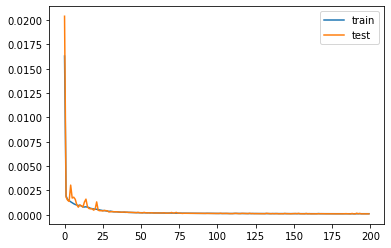

In [52]:
X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 200,50)

X_train=X_train.reshape((X_train.shape[0],2,200))
X_test=X_test.reshape((X_test.shape[0],2,200))
input_shape=(2,200)
# define encoder
n_inputs=200
visible = layers.Input(shape=(input_shape))
# encoder level 1
e = layers.Dense(n_inputs*2)(visible)
e = layers.BatchNormalization()(e)
e = layers.LeakyReLU()(e)
# encoder level 2
e = layers.Dense(n_inputs)(e)
e = layers.BatchNormalization()(e)
e = layers.LeakyReLU()(e)
# bottleneck
n_bottleneck = 100
bottleneck = layers.Dense(n_bottleneck)(e)
# define decoder, level 1
d = layers.Dense(n_inputs)(bottleneck)
d = layers.BatchNormalization()(d)
d = layers.LeakyReLU()(d)
# decoder level 2
d = layers.Dense(n_inputs*2)(d)
d = layers.BatchNormalization()(d)
d = layers.LeakyReLU()(d)
# output layer
output = layers.Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = tf.keras.models.Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = tf.keras.models.Model(inputs=visible, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')

In [53]:
# load the model from file
encoder = load_model('encoder.h5', compile=False)
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)



X_train_encode=X_train_encode.reshape((X_train_encode.shape[0],X_train_encode.shape[2],2))
X_test_encode=X_test_encode.reshape((X_test_encode.shape[0],X_test_encode.shape[2],2))

input_shape_cnn=(n_bottleneck,2)

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape_cnn))
model.add(layers.GaussianNoise(0.1))

for i in range(3):
    model.add(layers.Conv1D(filters=60, kernel_size=(2), padding='valid',activation='relu'))
    model.add(layers.Conv1D(filters=120, kernel_size=(8), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))

model.add(layers.Dense(units=200))

model.add(layers.Dense(units=800))


model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train_encode, y_train, batch_size=nb_slice, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
438/438 [==============================] - 4s 10ms/step - loss: 1.0979 - accuracy: 0.3508 - val_loss: 1.0989 - val_accuracy: 0.3340
Epoch 3/300
438/438 [==============================] - 4s 10ms/step - loss: 1.0972 - accuracy: 0.3477 - val_loss: 1.0977 - val_accuracy: 0.3574
Epoch 4/300
438/438 [==============================] - 4s 10ms/step - loss: 1.0966 - accuracy: 0.3510 - val_loss: 1.0969 - val_accuracy: 0.3580
Epoch 5/300
438/438 [==============================] - 4s 10ms/step - loss: 1.0936 - accuracy: 0.3631 - val_loss: 1.0997 - val_accuracy: 0.3442
Epoch 6/300
438/438 [==============================] - 4s 10ms/step - loss: 1.0922 - accuracy: 0.3546 - val_loss: 1.1002 - val_accuracy: 0.3570
Epoch 7/300
438/438 [==============================] - 4s 10ms/step - loss: 1.0882 - accuracy: 0.3643 - val_loss: 1.1027 - val_accuracy: 0.3340
Epoch 8/300
438/438 [==============================] - 4s 10ms/step - loss: 1.0834 - accuracy: 0.3704 - val_loss: 1.1021 - val_accuracy:

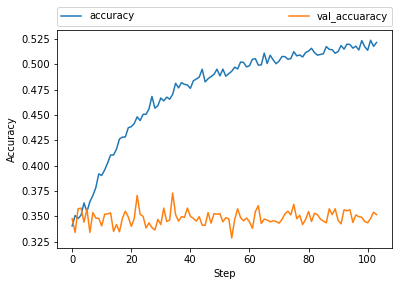

f1_score for each class
[0.16503667 0.21605667 0.48693938]
Global f1_score
0.2885963638030205
Global accuracy
0.3535462912831619


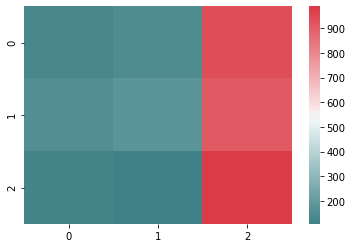

In [54]:
plot_accuracy(history)
test_metrics(model, y_test, X_test_encode)

This new approach does not seem to perform better at all, it even makes the model overfit a lot more.

## Autoencoder in CNN

We are trying a compression approach with an autoencoder as before, to reduce the dimension of the input. Above, the autoencoder was trained independantly from the CNN: we are now trying to train the two networks at the same time, to get weights in the autoencoder trained for our given situation.

In [35]:
X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 200, 50)


steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

#X_train=X_train.reshape((X_train.shape[0],2,200))
#X_test=X_test.reshape((X_test.shape[0],2,200))
#input_shape=(2,200)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))

#autoencoder
model.add(layers.Dense(200*2))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Dense(200))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
#bottleneck
model.add(layers.Dense(100))

#CNN
for i in range(3):
    model.add(layers.Conv1D(filters=60, kernel_size=(2), padding='valid',activation='relu'))
    model.add(layers.Conv1D(filters=120, kernel_size=(8), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))

model.add(layers.Dense(units=200))

model.add(layers.Dense(units=800))


model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=nb_slice, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Il y a 18468 échantillons
Epoch 1/300
438/438 [==============================] - 18s 40ms/step - loss: 1.0983 - accuracy: 0.3434 - val_loss: 1.1027 - val_accuracy: 0.3316
Epoch 2/300
438/438 [==============================] - 17s 38ms/step - loss: 1.0960 - accuracy: 0.3455 - val_loss: 1.0926 - val_accuracy: 0.3624
Epoch 3/300
438/438 [==============================] - 17s 38ms/step - loss: 1.0935 - accuracy: 0.3602 - val_loss: 1.0917 - val_accuracy: 0.3638
Epoch 4/300
438/438 [==============================] - 17s 38ms/step - loss: 1.0916 - accuracy: 0.3612 - val_loss: 1.0892 - val_accuracy: 0.3675
Epoch 5/300
438/438 [==============================] - 16s 38ms/step - loss: 1.0854 - accuracy: 0.3697 - val_loss: 1.0930 - val_accuracy: 0.3516
Epoch 6/300
438/438 [==============================] - 17s 38ms/step - loss: 1.0774 - accuracy: 0.3765 - val_loss: 1.0832 - val_accuracy: 0.3712
Epoch 7/300
438/438 [==============================] - 17s 38ms/step - loss: 1.0651 - accuracy: 0.3906 -

KeyboardInterrupt: 

In [ ]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

In [ ]:
name=print_graph(model, 'Autoencoder_in_CNN')
Image(retina=True, filename=name)

## Per packet prediction on test set

We tried tuning the above networks in order to get the best prediction accuracy for each slice of packet. Now, to boost the results, and inspired by the article "Fingerprinting Unmanned Aerial Vehicles withNon-standard Transmitter Waveforms", we are going to do a per packet prediction.   
On the train set, we are predicting a class for each slice, as above. Then we are predicting a class for the whole packet using the predictions from all of its corresponding slices. We will do this using either a Probability Sum (summing the probabilities of each class for each slice and taking the class with the highest sum) or Majority Vote (taking the most predicted class between all slices of the packet).   
To do that, we modified the inputs a little bit: first we shuffle all the packets so that packets from the same class are not all gathered. Then, after creating the slices for each packet, we do not shuffle them during the train_test_split: this way, slices from the same packet stay gathered in the test set. Nevertheless, we want these slices to be shuffled in the train set: we do that when fitting the model to the train set.   
We are tryning this approach on the CNN1 network, since it had one of the best f1-score, and the classes accuracy are fairly balanced.

In [37]:
X_train, X_test, y_train, y_test, input_shape, nb_slice=data_preparation_nn(idata, 'slice', 450, 30)

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1,input_shape=input_shape))

for i in range(3):
    model.add(layers.Conv1D(filters=140, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.Conv1D(filters=300, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))

model.add(layers.Dense(units=650))
model.add(layers.Dense(units=400))

model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

history=model.fit(x_train, y_train, batch_size=60,epochs=steps, verbose=1, validation_data=(x_valid, y_valid),
                 callbacks=[callback])


Il y a 24624 échantillons
Epoch 1/300
263/263 [==============================] - 47s 178ms/step - loss: 1.1018 - accuracy: 0.3486 - val_loss: 1.0973 - val_accuracy: 0.3536
Epoch 2/300
263/263 [==============================] - 46s 175ms/step - loss: 1.0823 - accuracy: 0.3760 - val_loss: 1.0821 - val_accuracy: 0.3820
Epoch 3/300
263/263 [==============================] - 45s 171ms/step - loss: 1.0590 - accuracy: 0.4003 - val_loss: 1.0658 - val_accuracy: 0.4074
Epoch 4/300
263/263 [==============================] - 47s 179ms/step - loss: 1.0285 - accuracy: 0.4205 - val_loss: 1.0484 - val_accuracy: 0.4033
Epoch 5/300
263/263 [==============================] - 47s 180ms/step - loss: 0.9886 - accuracy: 0.4533 - val_loss: 1.0278 - val_accuracy: 0.4624
Epoch 6/300
263/263 [==============================] - 47s 180ms/step - loss: 0.9533 - accuracy: 0.4840 - val_loss: 1.0016 - val_accuracy: 0.4901
Epoch 7/300
263/263 [==============================] - 47s 178ms/step - loss: 0.9133 - accuracy: 0

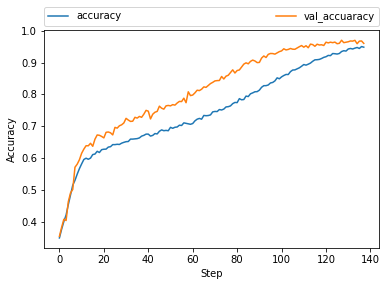

f1_score for each class
[0.40582294 0.40893703 0.48215297]
Global f1_score
0.43635008915550494
Global accuracy
0.4341116751269036


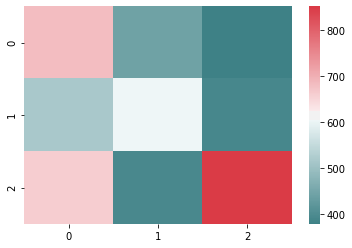

In [38]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

### Probability Sum

Now that the model is trained, we are predicting a class for each slice of the test set. Then, we add the probability vector of all the slices of the same packet in order to get a sum vector. The class with the highest sum will be the prediction for the packet.

In [42]:
predictions= model.predict(X_test)
print(predictions.shape)

y_test_cat = [np.argmax(y, axis=0, out=None) for y in y_test]

padd=len(y_test_cat)%nb_slice   #uncomplete packet at the beginning of the set
print(padd)

predictions=predictions[padd:]
y_test_cat=y_test_cat[padd:]

nb_packets=int(len(predictions)/nb_slice)
print(nb_packets)


packet_pred=list()
y_packet=list()
for i in range(nb_packets):
    packet=predictions[(i*nb_slice):(i+1)*nb_slice]
    preds=np.sum(packet, axis = 0)
    class_pred=np.where(preds == np.amax(preds))[0][0]
    packet_pred.append(class_pred)
    
    if len(np.unique(y_test_cat[(i*nb_slice):(i+1)*nb_slice]))!=1:
        print('FALSE')
    class_y=y_test_cat[i*nb_slice]
    y_packet.append(class_y)
    
print(packet_pred)
print(y_packet)

(4925, 3)
29
136
[2, 2, 1, 1, 2, 0, 2, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 2, 0, 0, 1, 2, 0, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 0]
[2, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 1, 1, 0, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 2, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 1, 2, 0, 2, 2, 0, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 0, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 0, 1, 1, 0, 2, 1, 2, 2, 0, 1, 0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 0]


Let's now compare these predictions with the actual results.

f1_score for each class
[0.54545455 0.52380952 0.6       ]
Global f1_score
0.5600267379679144
Global accuracy
0.5588235294117647


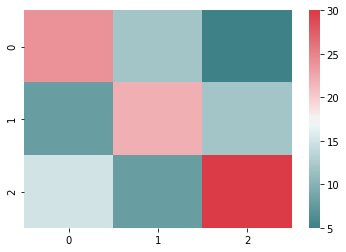

In [43]:
    
present_class_list=np.unique(y_packet)

# Confusion Matrix
conf_mat=confusion_matrix(y_packet, packet_pred, labels=present_class_list)

#F1-score
print("f1_score for each class")
f1_each=f1_score(y_packet, packet_pred, average=None, labels=present_class_list)
print(f1_each)

#F1-score
print("Global f1_score")
print(f1_score(y_packet, packet_pred, average='weighted'))

#accyracy
print("Global accuracy")
print(accuracy_score(y_packet,packet_pred))

cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

### Majority Vote

In [45]:
predictions= model.predict(X_test)
predictions_cat=[np.argmax(y, axis=0, out=None) for y in predictions]

y_test_cat = [np.argmax(y, axis=0, out=None) for y in y_test]

padd=len(y_test_cat)%nb_slice   #uncomplete packet
print(padd)

predictions_cat=predictions_cat[padd:]
y_test_cat=y_test_cat[padd:]

nb_packets=int(len(predictions)/nb_slice)
print(nb_packets)


packet_pred=list()
y_packet=list()
for i in range(nb_packets):
    packet=predictions_cat[(i*nb_slice):(i+1)*nb_slice]
    counts = np.bincount(packet)
    class_pred=np.argmax(counts)
    packet_pred.append(class_pred)
    
    if len(np.unique(y_test_cat[(i*nb_slice):(i+1)*nb_slice]))!=1:
        print('FALSE')
    class_y=y_test_cat[i*nb_slice]
    y_packet.append(class_y)
    
print(packet_pred)
print(y_packet)

29
136
[2, 2, 1, 1, 2, 0, 2, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 1, 2, 1, 1, 0, 1, 0, 1, 0, 2, 2, 2, 1, 2, 0, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 1, 2, 0, 1, 1, 0, 0]
[2, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 1, 1, 0, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 2, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 1, 2, 0, 2, 2, 0, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 0, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 0, 1, 1, 0, 2, 1, 2, 2, 0, 1, 0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 0]


f1_score for each class
[0.54945055 0.5        0.59405941]
Global f1_score
0.5515633900170883
Global accuracy
0.5514705882352942


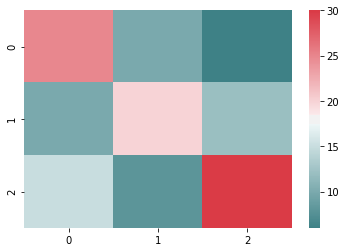

In [46]:
present_class_list=np.unique(y_packet)

# Confusion Matrix
conf_mat=confusion_matrix(y_packet, packet_pred, labels=present_class_list)

#F1-score
print("f1_score for each class")
f1_each=f1_score(y_packet, packet_pred, average=None, labels=present_class_list)
print(f1_each)

#F1-score
print("Global f1_score")
print(f1_score(y_packet, packet_pred, average='weighted'))

#accyracy
print("Global accuracy")
print(accuracy_score(y_packet,packet_pred))

cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

There seems to be a problem with the test set (probably due to shuffling) => need to be investigated